# Pre-Processing : Library and Data file import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)
pd.set_option('display.max_columns', 999)

In [2]:
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import gc

/Users/akhileshpandita/AnacondaParentFolder/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
import time
import warnings
warnings.filterwarnings("ignore")

In [16]:
import imblearn
import collections
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

In [4]:
gc.collect()

51

In [8]:
#df = pd.read_pickle("df.pkl")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60167008 entries, 1 to 67501978
Data columns (total 9 columns):
user_id          int64
product_id       int64
user_session     object
event_time       datetime64[ns, UTC]
event_type       object
category_id      int64
category_code    object
brand            object
price            float64
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 4.5+ GB


# 1. Processing data for appropriate Date-Time Values

In [10]:
#df = electronics[:5000].copy()
df.drop('category_id',axis=1,inplace=True)

In [11]:
df['event_time'] = pd.DatetimeIndex(df['event_time']).tz_convert('US/Eastern')

In [12]:
df['year'] = pd.DatetimeIndex(df['event_time']).year
df['month'] = pd.DatetimeIndex(df['event_time']).month

In [13]:
# Month

MM = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df['month'] = pd.DatetimeIndex(df['event_time']).month.map(MM)

In [14]:
# Weekday

dayOfWeek={0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fr', 5:'Sat', 6:'Sun'}
df['weekday'] = pd.DatetimeIndex(df['event_time']).weekday.map(dayOfWeek)

In [15]:
# Phase of day

df['hour'] = pd.DatetimeIndex(df['event_time']).hour
timeOfDay={0:'Dawn',1:'Dawn',2:'Dawn',3:'Dawn',4:'Dawn',5:'EarlyMorning',6:'EarlyMorning',7:'EarlyMorning',8:'EarlyMorning', 9:'Morning',10:'Morning',11:'Morning', 12:'Noon', 13:'Afternoon',14:'Afternoon',15:'Afternoon',16:'Afternoon', 17:'Evening',18:'Evening',19:'Evening',20:'Evening', 21:'Night',22:'Night',23:'Night', 24:'Midnight'}
df['timeOfDay'] = df.hour.map(timeOfDay)

In [16]:
# Is Weekend?

df['Weekend']= df.weekday.apply(lambda x : 1 if x in ['Sunday','Saturday'] else 0)

In [201]:
#Holdiays not included due to computational issues

In [186]:
# #Is holiday?

#holidaysDF = pd.read_csv("holidays.csv")
#holidaysDF['Date']= pd.DatetimeIndex(holidaysDF['Date']).tz_localize('UTC').tz_convert('US/Eastern')
# holidaysList = []

# for item in holidaysDF['Date'].to_list():
#     holidaysList.append(pd.Timestamp(item))

# Holiday = df.event_time.apply(lambda x : 1 if x in holidaysList else 0)
# df['Holiday']= Holiday

In [202]:
df.head(1)

,user_id,product_id,user_session,event_time,event_type,category_code,brand,price,year,month,weekday,hour,timeOfDay,Weekend,OverallAmtUserCarted,OverallAmtUserPurchased,OverallAmtUserViewed,dummy
0,554748717,3900821,9333dfbd-b87a-4708-9857-6336556b0fcc,2019-09-30 20:00:00-04:00,view,appliances.environment.water_heater,aqua,33.2,2019,Sep,Mon,20,Evening,0,0.0,0.0,92.52,0.0


Adding COLUMNS TO DF -  AMOUNT BY USER for all events

In [19]:
AmountbyUser = pd.pivot_table(df, index='user_id',columns='event_type',values='price',fill_value=0)

In [20]:
AmountbyUser = AmountbyUser.rename(columns={'cart':'OverallAmtUserCarted','purchase':'OverallAmtUserPurchased','view':'OverallAmtUserViewed'})

In [21]:
df = pd.merge(df,AmountbyUser,on='user_id',how='outer')

In [22]:
# SAVE TO PICKLE
#df.to_pickle("df.pkl")

In [23]:
#READ FROM PICKLE
df = pd.read_pickle("df.pkl")

# 2. Creating Features

## Features to build:

    Weekday(Sun/Mon/...) [One hot encoded]
    Month [One hot encoded]
    TimeOfDay(Morning/Evening/....) [One hot encoded]
    InteractionTime(Duration of Session in seconds)
    
    #TotalEventsInSession()
    #ViewEventsInSession
    #CartEventsInSession
    
    #CategoriesViewedInSession
    #CategoriesCartedInSession
    #BrandsViewedInSession
    #BrandsCartedInSession
    #ProductsViewedInSession
    #ProductsCartedInSession
    
    AverageAmountViewedInSession
    AverageAmountCartedInSession
    
    #HolidaysDuringSession()
    #WeekendDuringSession()
    
    LastSession(1: if the Session is last for a user, 0 if not)
    
    ViewToCartTime (Time between viewing and carting in session)
    
    Other suggested Features:
        AvgPRDViewbyUser (total products viewed/total sessions by user)
        AvgPRDCartbyUser  (total products carted/total sessions by user)
        AvgCTGViewbyUser (total categories viewed/total sessions by user)
        AvgCTGCartbyUser (total categories viewed/total sessions by user)

## GROUPING THE DATA

In [24]:
GroupUS = df.sort_values('event_time').groupby(['user_session'])

## Total Number of Events/Interactions in Session

In [25]:
Features= GroupUS['event_type'].count().reset_index().rename(columns={'event_type':'TotalEventsInSession'})

## Duration

In [26]:
# # Defining function to return range of any given series
def ammd(series):
    return (max(series)-min(series))

In [27]:
interactionTime = GroupUS['event_time'].agg(ammd)

In [28]:
interactionTime = interactionTime.dt.total_seconds()

In [32]:
Features.set_index('user_session', inplace=True)

In [200]:
#Join is MUCH FASTER than Merge

In [40]:
start_time = time.time()
Features = Features.join(interactionTime, how='left')
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.4988081455230713 seconds ---


In [37]:
# start_time = time.time()
# X2 = pd.merge(Features,interactionTime, how ='outer', on = 'user_session')
# print("--- %s seconds ---" % (time.time() - start_time))

--- 33.254327058792114 seconds ---


In [41]:
Features = Features.rename(columns={'event_time':'interactionTime'})

In [42]:
Features.head(2)

,TotalEventsInSession,interactionTime
user_session,,
00000056-a206-40dd-b174-a072550fa38c,7,493.0
00000083-8816-4d58-a9b8-f52f54186edc,18,585.0


##  Number of Interactions by Event Type in Session

In [43]:
NumEventTime = GroupUS['event_type'].value_counts().unstack(fill_value = 0).rename(columns={'view':'#TimesViewedinSession','cart':'#TimesCartedinSession','purchase':'#TimesPurchasedinSession'})

In [46]:
Features = Features.join(NumEventTime, how='left')

In [199]:
Features.head(1)

,user_session,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesPurchasedinSession,#TimesViewedinSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtPurchasedInSession,AvgAmtViewedInSession,#BrandsCartedInSession,#BrandsPurchasedInSession,#BrandsViewedInSession,#CategoriesCartedInSession,#CategoriesPurchasedInSession,#CategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,OverallAmtUserPurchased,#ProdsCartedInSession,#ProdsPurchasedInSession,#ProdsViewedInSession,Fr,Mon,Sat,Sun,Thu,Tue,Wed,2019,Nov,Oct,Sep,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Weekend,Purchase
0,00000056-a206-40dd-b174-a072550fa38c,7,493.0,0,0,7,1349.46,131.53,0.0,0.0,812.941429,0,0,7,0,0,7,145.095,187.166429,98.97,0,0,7,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0


In [934]:
#Features = pd.merge(Features,NumEventTime, how ='outer', on = ['user_session'])

## Max and Min Price

In [48]:
Features['maxPrice'] = GroupUS['price'].max().values

In [49]:
Features['minPrice'] = GroupUS['price'].min().values

## AVERAGE AMOUNT BY EVENT IN SESSION

In [50]:
AmountbyEvent = pd.pivot_table(df, index='user_session',columns='event_type',values='price',fill_value=0)
AmountbyEvent = AmountbyEvent.rename(columns={'cart':'AvgAmtCartedInSession','purchase':'AvgAmtPurchasedInSession','view':'AvgAmtViewedInSession'})

In [51]:
Features = Features.join(AmountbyEvent, how='left')

In [52]:
Features.head(1)

,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesPurchasedinSession,#TimesViewedinSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtPurchasedInSession,AvgAmtViewedInSession
user_session,,,,,,,,,,
00000056-a206-40dd-b174-a072550fa38c,7,493.0,0,0,7,1349.46,131.53,0.0,0.0,812.941429


In [936]:
#Features = pd.merge(Features,AmountbyEvent,on='user_session',how='outer')

## BRAND COUNT BY EVENT IN SESSION

In [53]:
BrandsBySession= pd.pivot_table(df, index='user_session',columns='event_type',values='brand',aggfunc='count',fill_value=0)
BrandsBySession = BrandsBySession.rename(columns={'view':'#BrandsViewedInSession','cart':'#BrandsCartedInSession','purchase':'#BrandsPurchasedInSession'})

In [55]:
Features = Features.join(BrandsBySession, how='left')

In [ ]:
#Features = pd.merge(Features,BrandsBySession,on='user_session',how='outer')

## CATEGORY COUNT BY EVENT IN SESSION

In [56]:
CategoriesBySession= pd.pivot_table(df, index='user_session',columns='event_type',values='category_code',aggfunc='count',fill_value=0)
CategoriesBySession = CategoriesBySession.rename(columns={'view':'#CategoriesViewedInSession','cart':'#CategoriesCartedInSession','purchase':'#CategoriesPurchasedInSession'})

In [57]:
Features = Features.join(CategoriesBySession, how='left')

In [938]:
#Features = pd.merge(Features,CategoriesBySession,on='user_session',how='outer')

## ADDING FEATURES FOR AVERAGE OVERALL AMOUNT BY USER FOR DIFFERENT EVENTS

In [61]:
OverallAmtUserCarted = df.groupby('user_session')['OverallAmtUserCarted'].mean()

In [62]:
OverallAmtUserViewed = df.groupby('user_session')['OverallAmtUserViewed'].mean()

In [63]:
OverallAmtUserPurchased = df.groupby('user_session')['OverallAmtUserPurchased'].mean()

In [64]:
#Merging these individual dataframes

#Features = pd.merge(Features,OverallAmtUserCarted.reset_index(), how='outer',on = ['user_session'])
Features = Features.join(OverallAmtUserCarted, how='left')

In [65]:
#Features = pd.merge(Features,OverallAmtUserViewed.reset_index(), how='outer',on = ['user_session'])
Features = Features.join(OverallAmtUserViewed, how='left')

In [66]:
#Features = pd.merge(Features,OverallAmtUserPurchased.reset_index(), how='outer',on = ['user_session'])
Features = Features.join(OverallAmtUserPurchased, how='left')

## PRODUCT COUNT BY EVENT IN SESSION

In [68]:
ProductsBySession = pd.pivot_table(df, index='user_session',columns='event_type',values='product_id',aggfunc='count',fill_value=0)
ProductsBySession = ProductsBySession.rename(columns={'view':'#ProdsViewedInSession','cart':'#ProdsCartedInSession','purchase':'#ProdsPurchasedInSession'})

In [69]:
#Features = pd.merge(Features,ProductsBySession,on='user_session',how='outer')
Features = Features.join(ProductsBySession, how='left')

In [70]:
Features.head(1)

,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesPurchasedinSession,#TimesViewedinSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtPurchasedInSession,AvgAmtViewedInSession,#BrandsCartedInSession,#BrandsPurchasedInSession,#BrandsViewedInSession,#CategoriesCartedInSession,#CategoriesPurchasedInSession,#CategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,OverallAmtUserPurchased,#ProdsCartedInSession,#ProdsPurchasedInSession,#ProdsViewedInSession
user_session,,,,,,,,,,,,,,,,,,,,,,
00000056-a206-40dd-b174-a072550fa38c,7,493.0,0,0,7,1349.46,131.53,0.0,0.0,812.941429,0,0,7,0,0,7,145.095,187.166429,98.97,0,0,7


Adding a dummy column for one-hot encoding values easily

In [71]:
df['dummy']= np.zeros(len(df))

## Adding Date and Time Features 

In [72]:
weekday = pd.pivot_table(df, index='user_session',columns='weekday',values='dummy',fill_value=0, aggfunc=lambda x: len(x.unique()) )

In [98]:
year =  pd.pivot_table(df, index='user_session',columns='year',values='dummy',fill_value=0, aggfunc=lambda x: len(x.unique()) )

In [99]:
month =  pd.pivot_table(df, index='user_session',columns='month',values='dummy',fill_value=0, aggfunc=lambda x: len(x.unique()) )

In [166]:
timeOfDay =  pd.pivot_table(df, index='user_session',columns='timeOfDay',values='dummy',fill_value=0, aggfunc=lambda x: len(x.unique()) )

Merging these date and time features

In [167]:
#Features = pd.merge(Features,weekday,on='user_session',how='outer')
Features = Features.join(weekday, how='left')

In [168]:
#Features = pd.merge(Features,year,on='user_session',how='outer')
Features = Features.join(year, how='left')

In [169]:
#Features = pd.merge(Features,month,on='user_session',how='outer')
Features = Features.join(month, how='left')

In [170]:
#Features = pd.merge(Features,timeOfDay,on='user_session',how='outer')
Features = Features.join(timeOfDay, how='left')

In [198]:
#Holdiays not included due to computational issues

In [951]:
#Holiday = GroupUS['Holiday'].sum()
## Features = pd.merge(Features,Holiday,on='user_session',how='outer')
# Features = Features.join(Holiday, how='left')


In [172]:
#Features = pd.merge(Features,Weekend,on='user_session',how='outer')
Weekend = GroupUS['Weekend'].sum()

In [173]:
Features = Features.join(Weekend, how='left')

## Dropping all Purchase related Columns and adding Y label 'Purchase'

In [175]:
Features['Purchase'] = Features.AvgAmtPurchasedInSession.apply(lambda x : 1 if x!=0 else 0)

In [191]:
Features.reset_index(inplace=True)

In [192]:
Features.columns

Index([                 'user_session',          'TotalEventsInSession',
                     'interactionTime',         '#TimesCartedinSession',
            '#TimesPurchasedinSession',         '#TimesViewedinSession',
                            'maxPrice',                      'minPrice',
               'AvgAmtCartedInSession',      'AvgAmtPurchasedInSession',
               'AvgAmtViewedInSession',        '#BrandsCartedInSession',
           '#BrandsPurchasedInSession',        '#BrandsViewedInSession',
          '#CategoriesCartedInSession', '#CategoriesPurchasedInSession',
          '#CategoriesViewedInSession',          'OverallAmtUserCarted',
                'OverallAmtUserViewed',       'OverallAmtUserPurchased',
               '#ProdsCartedInSession',      '#ProdsPurchasedInSession',
               '#ProdsViewedInSession',                            'Fr',
                                 'Mon',                           'Sat',
                                 'Sun',            

In [194]:
FeaturesDF = Features.drop(columns=['user_session',
                                    '#TimesPurchasedinSession',
                                    '#BrandsPurchasedInSession', 
                                    'AvgAmtPurchasedInSession',
                                    '#CategoriesPurchasedInSession',
                                   'OverallAmtUserPurchased',
                                   '#ProdsPurchasedInSession'])

In [195]:
FeaturesDF.sort_values(by='Purchase',ascending=False)

,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesViewedinSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtViewedInSession,#BrandsCartedInSession,#BrandsViewedInSession,#CategoriesCartedInSession,#CategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,#ProdsCartedInSession,#ProdsViewedInSession,Fr,Mon,Sat,Sun,Thu,Tue,Wed,2019,Nov,Oct,Sep,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Weekend,Purchase
14052979,6,335.0,2,3,128.42,128.42,128.42,128.420000,2,3,2,3,128.420000,173.510000,2,3,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
1823969,9,201.0,2,5,1362.69,291.27,826.98,934.122000,2,5,2,5,615.473333,625.244000,2,5,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1
1823988,3,680.0,1,1,278.77,278.77,278.77,278.770000,1,1,1,1,278.770000,256.976667,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,1
1823982,4,133.0,1,2,138.23,138.23,138.23,138.230000,1,2,1,2,138.230000,122.011000,1,2,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1
12355648,6,402.0,2,3,152.82,127.93,152.82,144.523333,2,3,2,3,217.574000,416.237143,2,3,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4853053,2,89.0,0,2,38.96,38.33,0.00,38.645000,0,2,0,2,23.140000,328.772953,0,2,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0
4853054,1,0.0,0,1,242.40,242.40,0.00,242.400000,0,1,0,1,247.315000,236.128480,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0
4853055,2,16.0,0,2,1567.30,1541.58,0.00,1554.440000,0,2,0,2,1003.620000,962.399434,0,2,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0
4853056,1,0.0,0,1,131.76,131.76,0.00,131.760000,0,1,0,1,131.760000,131.760000,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0


In [210]:
print("The features we have are as follows: \n", FeaturesDF.columns.tolist())

print('************')
print("PLEASE NOTE THAT \n One-Hot-Encoded Date and Time features are dynamically added as per data")
print('************')

The features we have are as follows: 
 ['TotalEventsInSession', 'interactionTime', '#TimesCartedinSession', '#TimesViewedinSession', 'maxPrice', 'minPrice', 'AvgAmtCartedInSession', 'AvgAmtViewedInSession', '#BrandsCartedInSession', '#BrandsViewedInSession', '#CategoriesCartedInSession', '#CategoriesViewedInSession', 'OverallAmtUserCarted', 'OverallAmtUserViewed', '#ProdsCartedInSession', '#ProdsViewedInSession', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', 2019, 'Nov', 'Oct', 'Sep', 'Afternoon', 'Dawn', 'EarlyMorning', 'Evening', 'Morning', 'Night', 'Noon', 'Weekend', 'Purchase']
************
PLEASE NOTE THAT 
 One-Hot-Encoded Date and Time features are dynamically added as per data
************


### Saving Final FeaturesDF as pickle

In [197]:
#FeaturesDF.to_pickle("FeaturesDF.pkl")

In [5]:
FeaturesDF = pd.read_pickle('FeaturesDF.pkl')

### Splitting Training and Testing Data

In [7]:
XData = FeaturesDF.loc[:,:'Weekend']
YData = FeaturesDF.loc[:,'Purchase']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(XData,YData,test_size=0.2,random_state=42)

SCALING DATA WITH MINMAX SCALER

In [9]:
MMscaler = MinMaxScaler()
X_train = MMscaler.fit_transform(X_train)
X_test = MMscaler.transform(X_test)

### Saving train and test data in pickles

In [21]:
# np.save('X_train.npy', X_train)
# np.save('X_test.npy', X_test)
# np.save('y_train.npy', y_train)
# np.save('y_test.npy', y_test)

In [ ]:
np.load('X_train.npy')
np.load('X_test.npy')
np.load('y_train.npy')
np.load('y_test.npy')

## Measuring Feature Relevance

In [338]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(XData)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
pcaDF = pd.concat([principalDf, YData], axis = 1)

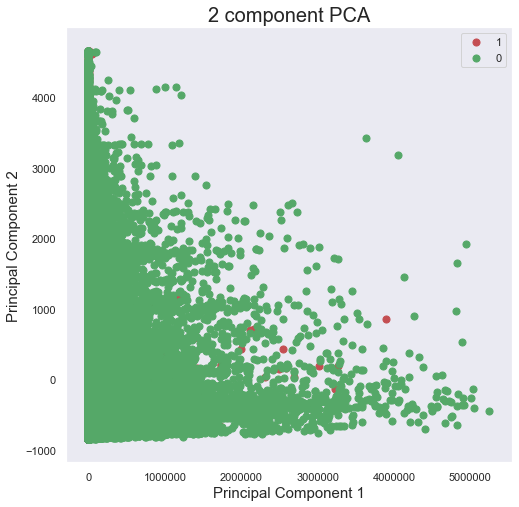

In [329]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,0]
colors = ['r', 'g']

for T, C in zip(targets,colors):
    indicesToKeep = pcaDF['Purchase'] == T
    ax.scatter(pcaDF.loc[indicesToKeep, 'principal component 1'], pcaDF.loc[indicesToKeep, 'principal component 2'], c = C, s = 50)

ax.legend(targets)
ax.grid()
plt.show()

In [339]:
pca.explained_variance_ratio_.cumsum()

array([0.99905764, 0.99974389])

# 3. Feature Ranking

## USING RANDOM FOREST

In [219]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))

In [220]:
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=None, verbose=0,
  

In [221]:
sel.get_support()

array([ True,  True,  True,  True, False, False,  True, False,  True,
        True,  True,  True, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [222]:
selected_feat= XData.columns[(sel.get_support())]

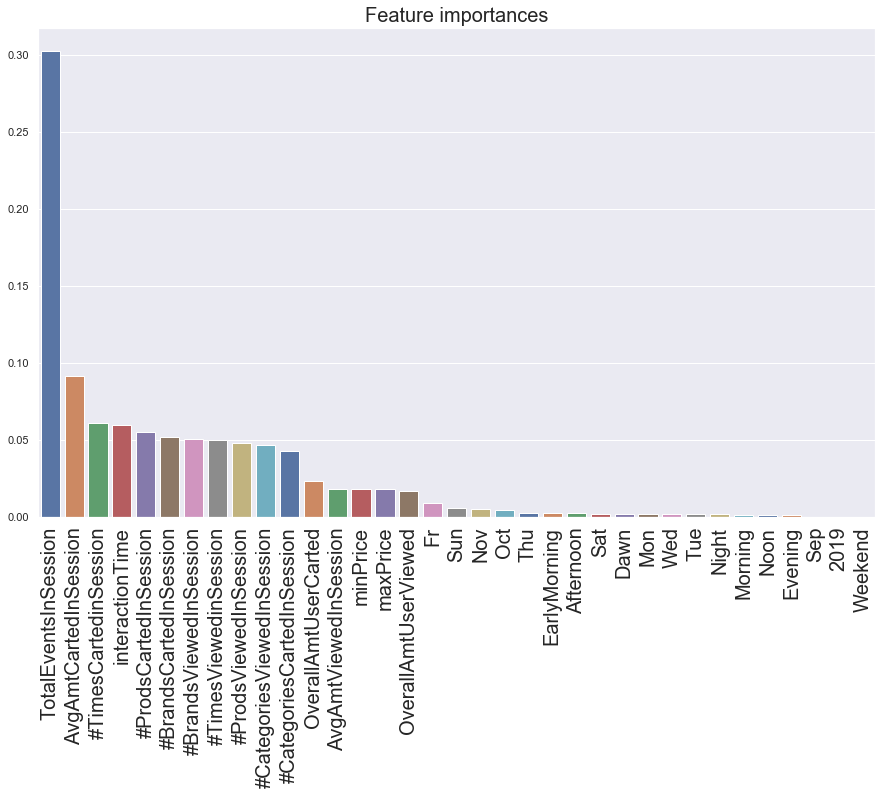

In [223]:
importances = sel.estimator_.feature_importances_
indices = np.argsort(importances)[::-1] 
colname = XData.columns[indices]
plt.figure(figsize=(15,9))
plt.title("Feature importances",size=20)
sns.barplot(x=colname, y=importances[indices],palette="deep")
plt.xticks(rotation=90,size=20)
plt.show()

## Using F Scores

In [224]:
import sklearn.feature_selection as fs
kb = fs.SelectKBest(k=X_train.shape[1])

In [227]:
kb.fit(X_train, y_train)

SelectKBest(k=35, score_func=<function f_classif at 0x7f7efa1c8cb0>)

In [228]:
names = XData.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]

In [229]:
names_scores = list(zip(names, scores))

In [230]:
fScoreDF = pd.DataFrame(data = names_scores, columns=['Feat_names','F_Scores'])
fScoreDF_sorted = fScoreDF.sort_values(['F_Scores','Feat_names'], ascending =[False, True])

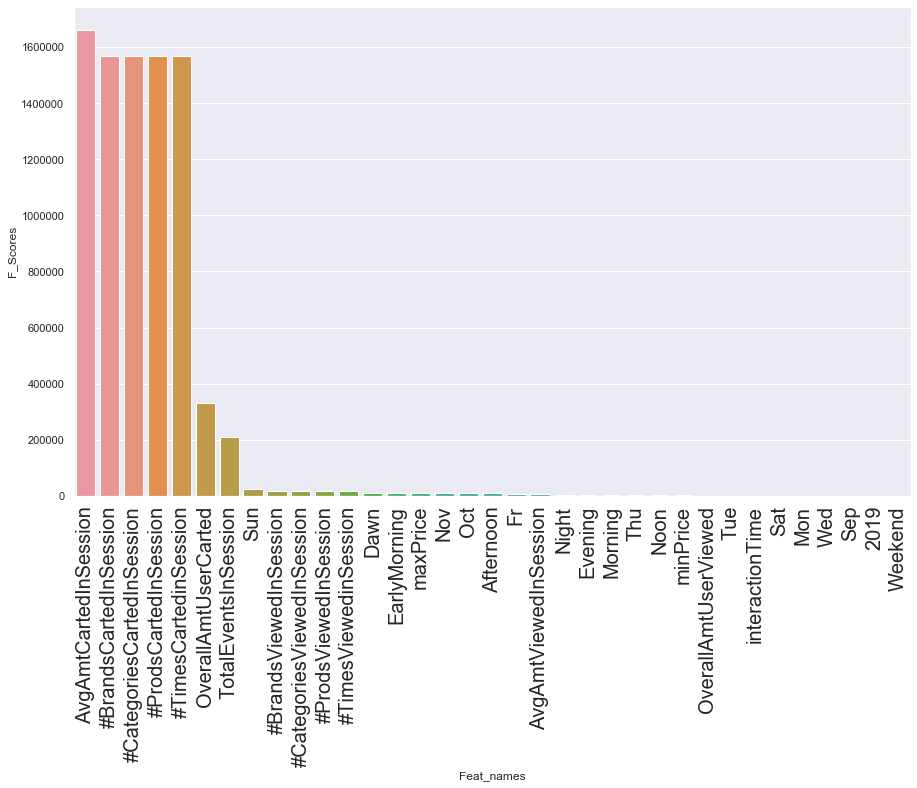

In [231]:
plt.figure(figsize=(15,9))
sns.barplot(x= "Feat_names", y="F_Scores",data=fScoreDF_sorted)
plt.xticks(rotation=90,size=20)
plt.show()

## XGBoosting

In [233]:
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot

In [234]:
XGB = XGBClassifier()

In [235]:
XGB.fit(X_train, y_train)

[23:14:27] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)

In [310]:
feature_importance = XGB.get_booster().get_score(importance_type='gain')

By GAIN

‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on.

In [311]:
XGBkeys = list(feature_importance.keys())
XGBvalues = list(feature_importance.values())

In [312]:
XGBdata = pd.DataFrame(data=XGBvalues, index=XGBkeys, columns=["score"]).sort_values(by = "score", ascending=False)
XGBdata= XGBdata.reset_index()
XGBdata = XGBdata.rename(columns={'index':'feature'})
XGBdata.feature = XGBdata.feature.apply(lambda x: x.strip('f'))
XGBdata.feature = XGBdata.feature.apply(lambda x: XData.columns[int(x)])

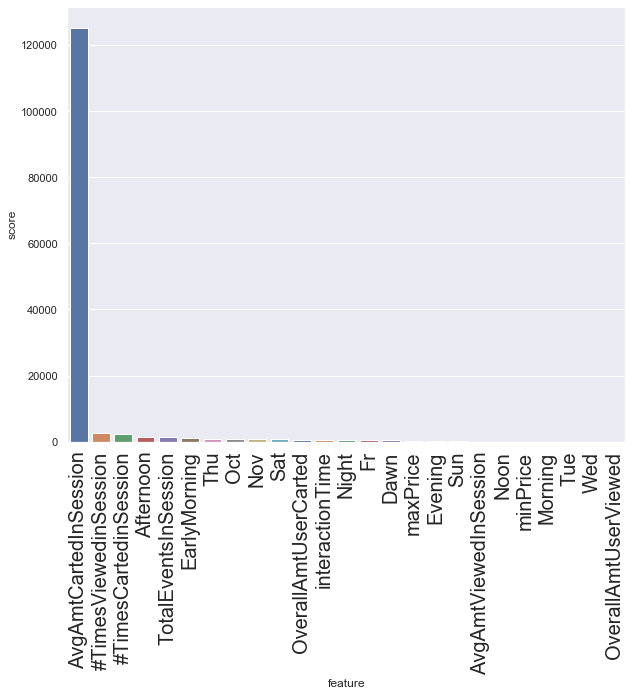

In [319]:
plt.figure(figsize=(10,8))
sns.barplot(x=XGBdata.feature, y=XGBdata.score,palette="deep")
plt.xticks(rotation=90,size=20)
plt.show()

#### By WEIGHT

In [314]:
feature_importance1 = XGB.get_booster().get_score(importance_type='weight')

In [315]:
XGBkeys1 = list(feature_importance1.keys())
XGBvalues1 = list(feature_importance1.values())

In [316]:
XGBdata1 = pd.DataFrame(data=XGBvalues1, index=XGBkeys1, columns=["score"]).sort_values(by = "score", ascending=False)
XGBdata1 = XGBdata1.reset_index()
XGBdata1 = XGBdata1.rename(columns={'index':'feature'})
XGBdata1.feature = XGBdata1.feature.apply(lambda x: x.strip('f'))
XGBdata1.feature = XGBdata1.feature.apply(lambda x: XData.columns[int(x)])

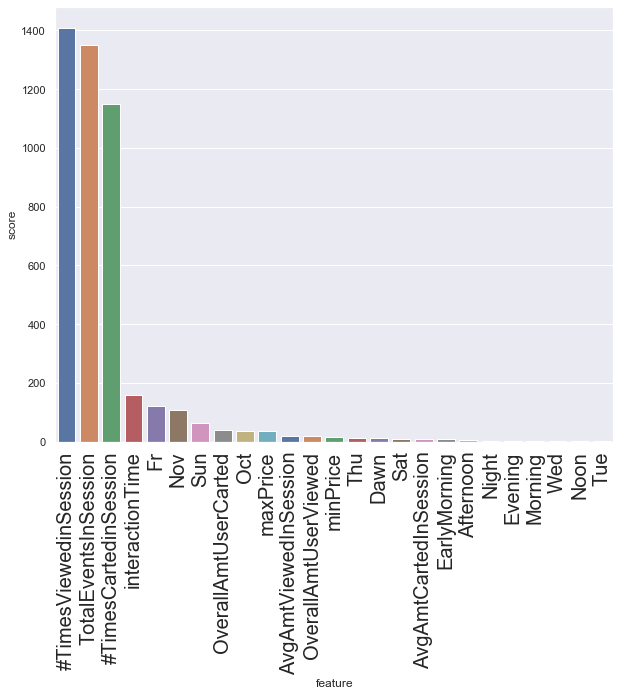

In [318]:
plt.figure(figsize=(10,8))
sns.barplot(x=XGBdata1.feature, y=XGBdata1.score,palette="deep")
plt.xticks(rotation=90,size=20)
plt.show()

## Condensing Features based on Above 4 Results

In [15]:
XData.columns

Index([      'TotalEventsInSession',            'interactionTime',
            '#TimesCartedinSession',      '#TimesViewedinSession',
                         'maxPrice',                   'minPrice',
            'AvgAmtCartedInSession',      'AvgAmtViewedInSession',
           '#BrandsCartedInSession',     '#BrandsViewedInSession',
       '#CategoriesCartedInSession', '#CategoriesViewedInSession',
             'OverallAmtUserCarted',       'OverallAmtUserViewed',
            '#ProdsCartedInSession',      '#ProdsViewedInSession',
                               'Fr',                        'Mon',
                              'Sat',                        'Sun',
                              'Thu',                        'Tue',
                              'Wed',                         2019,
                              'Nov',                        'Oct',
                              'Sep',                  'Afternoon',
                             'Dawn',               'EarlyMorni

Important Features found in common are:
1. 

# SMOTE

In [11]:
from imblearn.over_sampling import SMOTE

In [12]:
collections.Counter(YData)

Counter({0: 13074925, 1: 978055})


In [13]:
oversample = SMOTE()

In [14]:
X, Y = oversample.fit_resample(XData, YData)

Plotting before and after SMOTE

In [30]:
counter = Counter(YData)

Counter({0: 13074925, 1: 978055})


In [31]:
Counter(Y)

Counter({0: 13074925, 1: 13074925})


Saving SMOTE XData and YData to pickle

In [25]:
# X.to_pickle("XDataSMOTE.pkl")
# Y.to_pickle("YDataSMOTE.pkl")

In [ ]:
X = pd.read_pickle("XDataSMOTE.pkl")
Y = pd.read_pickle("YDataSMOTE.pkl")

### FEATURE RELEVANCE AFTER SMOTE

In [32]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
pcaDF = pd.concat([principalDf, Y], axis = 1)

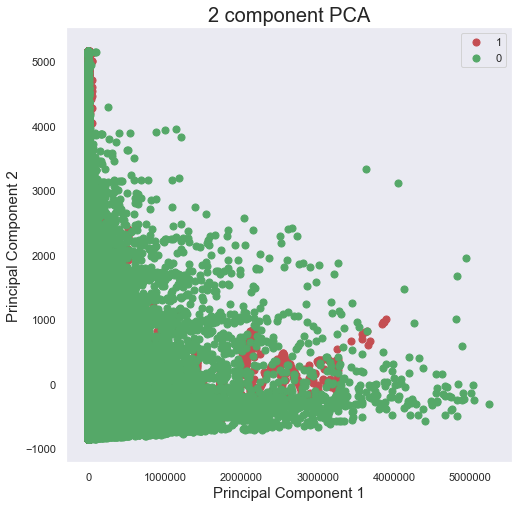

In [33]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,0]
colors = ['r', 'g']

for T, C in zip(targets,colors):
    indicesToKeep = pcaDF['Purchase'] == T
    ax.scatter(pcaDF.loc[indicesToKeep, 'principal component 1'], pcaDF.loc[indicesToKeep, 'principal component 2'], c = C, s = 50)

ax.legend(targets)
ax.grid()
plt.show()

# BASELINING - USING KNN - WITHOUT SMOTE

In [28]:
pca = PCA(.95)

In [35]:
pca.fit(X_train)

PCA(n_components=0.95)

In [36]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [39]:
KNN = KNeighborsClassifier(n_neighbors = 4)

In [41]:
y_pred = cross_val_predict(KNN, X_train, y_train, cv=5)

In [42]:
print(metrics.accuracy_score(y_train, y_pred))

0.9303563194425666


In [43]:
KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [44]:
y_predFinal = KNN.predict(X_test)

In [45]:
print(metrics.accuracy_score(y_test, y_predFinal))

0.9305759347839391


In [46]:
cnf_matrix = confusion_matrix(y_test, y_predFinal)
cnf_matrix

array([[2581928,   32985],
       [ 162138,   33545]])

Text(0.5, 3.5, 'Predicted label')

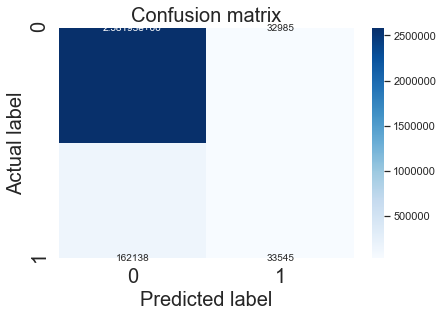

In [47]:
# name  of classes
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names,size=20)
plt.yticks(tick_marks, class_names,size=20)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix',size = 20)
plt.ylabel('Actual label',size = 20)
plt.xlabel('Predicted label',size = 20)

In [48]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predFinal))
print("Precision:",metrics.precision_score(y_test, y_predFinal))
print("Recall:",metrics.recall_score(y_test, y_predFinal))

Accuracy: 0.9305759347839391
Precision: 0.5042086276867579
Recall: 0.17142521322751594


# BASELINING - USING KNN - WITH SMOTE

X and Y are the balanced/SMOTED XData and YData
Splitting them in test and train

In [22]:
trainX, testX, trainY, testY = train_test_split(X,Y,test_size=0.2,random_state=42)

In [26]:
MMscaler = MinMaxScaler()
trainX = MMscaler.fit_transform(trainX)
testX = MMscaler.transform(testX)

In [29]:
pca.fit(trainX)

PCA(n_components=0.95)

In [30]:
trainX = pca.transform(trainX)
testX = pca.transform(testX)

### SAVING SMOTED TRAIN AND TEST DATA

In [32]:
# np.save('trainX.npy', trainX)
# np.save('testX.npy', testX)
# np.save('trainY.npy', trainY)
# np.save('testY.npy', testY)

In [ ]:
np.load('trainX.npy')
np.load('testX.npy')
np.load('trainY.npy')
np.load('testY.npy')

In [31]:
KNN = KNeighborsClassifier(n_neighbors = 4)

In [33]:
predY = cross_val_predict(KNN, trainX, trainY, cv=5)

In [34]:
print(metrics.accuracy_score(trainY, predY))

0.9576671089891529


In [35]:
KNN.fit(trainX, trainY)

KNeighborsClassifier(n_neighbors=4)

In [36]:
predFinalY = KNN.predict(testX)

In [37]:
print(metrics.accuracy_score(testY, predFinalY))

0.9582280586695526


In [38]:
cnf_matrix_SMOTE = confusion_matrix(testY, predFinalY)
cnf_matrix_SMOTE

array([[2561428,   52441],
       [ 166025, 2450076]])

In [39]:
print("Accuracy:",metrics.accuracy_score(testY, predFinalY))
print("Precision:",metrics.precision_score(testY, predFinalY))
print("Recall:",metrics.recall_score(testY, predFinalY))

Accuracy: 0.9582280586695526
Precision: 0.9790446977982568
Recall: 0.9365372361388188


Text(0.5, 3.5, 'Predicted label SMOTE')

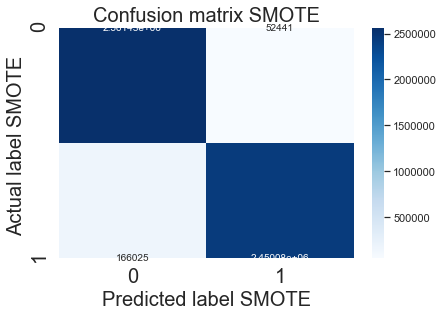

In [40]:
# name  of classes
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names,size=20)
plt.yticks(tick_marks, class_names,size=20)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_SMOTE), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix SMOTE',size = 20)
plt.ylabel('Actual label SMOTE ',size = 20)
plt.xlabel('Predicted label SMOTE',size = 20)